In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import ipyvolume as ipv
from ipywidgets import FloatProgress
from IPython.display import display, Image

from tyssue import HistoryHdf5, EventManager

from tyssue.draw import sheet_view, browse_history
from tyssue.geometry.bulk_geometry import ClosedMonolayerGeometry as geom
from tyssue.io import hdf5
from tyssue.dynamics import model_factory, effectors
from tyssue.generation.shapes import spherical_monolayer

from tyssue.behaviors import EventManager
from tyssue.behaviors import increase, decrease, reconnect
from tyssue.solvers.viscous import EulerSolver
from tyssue.utils.decorators import face_lookup


from tyssue.draw import highlight_faces, create_gif
from tyssue.solvers.quasistatic import QSSolver


from tyssue import HistoryHdf5



from pathlib import Path

from tyssue.utils.decorators import cell_lookup
from tyssue.topology.monolayer_topology import cell_division



Reference: https://elifesciences.org/articles/32943


It is conveninent to consider that cells have an average volume of 1


| stade  | nombe de cellules | volume interne (μm3) |
| ------ | --------- | ---------- |
| 3 | 120 | 181008 |
| 4 | 200 | 670400 |
| 5 | 400 | 3352000 | 
| 6 | 700 | 12318600 | 

## Experimental data

In [2]:
growth = pd.DataFrame(
    data=[[120, 181000], [200, 670400], [400, 3352000], [700, 12318600]],
    index=pd.Index([3, 4, 5, 6], name='stage'),
    columns=['Nc', 'lumen_vol']
)
growth

,Nc,lumen_vol
stage,,
3,120,181000
4,200,670400
5,400,3352000
6,700,12318600


$$
\ln(V_\mathrm{lum})(t) = a + k_V t\\
V_\mathrm{lum}(t) = V_0 e^{k_V t}
$$



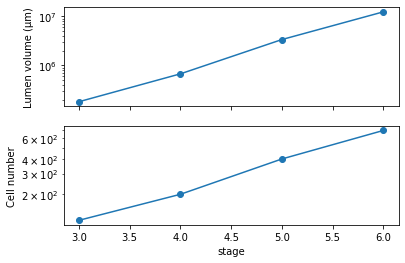

In [3]:
fig, (ax_v, ax_c) = plt.subplots(2, sharex=True)

ax_v.plot(growth.lumen_vol, '-o')
ax_v.set_yscale('log')
ax_v.set_ylabel('Lumen volume (µm)')

ax_c.plot(growth.Nc, '-o')
ax_c.set_yscale('log')
ax_c.set_ylabel('Cell number')
_ = ax_c.set_xlabel("stage")


In [4]:
kV, lnV0 = np.polyfit(growth.index, np.log(growth.lumen_vol), 1)

print(f"Lumen volume growth rate: {kV:.2f}")

kD, lnc0 = np.polyfit(growth.index, np.log(growth.Nc), 1)

print(f"Division rate: {kD:.2f}")


Lumen volume growth rate: 1.43
Division rate: 0.60


## Follicle monolayer creation


In [6]:
# Number of cells
Nc = 200

In [7]:
follicle = spherical_monolayer(9., 12., Nc, apical='in')
follicle.settings["lumen_side"] = "apical"

geom.update_all(follicle)
geom.scale(follicle, follicle.cell_df.vol.mean()**(-1/3), list("xyz"))
geom.update_all(follicle)


for df in follicle.datasets.values():
    df.dropna(axis=1, how='any', inplace=True)

print(f"Follicle has {follicle.Nc} cells")

Follicle has 213 cells


In [8]:
print(follicle.settings)

{'lumen_side': 'apical', 'lumen_vol': 157.79423058717543}


In [9]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}


In [10]:
ipv.clear()
follicle.face_df['visible'] = (follicle.face_df['y'] > 0) | (follicle.face_df['x'] > 0)
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [23]:
bck0.settings

{'lumen_side': 'apical', 'lumen_vol': 157.79423058717543}

In [14]:
bck0 = follicle.copy()

## Mechanical model


By analogy with 2D Manning model (by a suggestion she did during a communication, I assume this will be published some time) we can write the basic potiential with

$$
E = \frac{K_\ell}{2}(V_\ell - V_\ell^0)^2 + \sum_c \frac{K_v}{2}(V_c - V_c^0)^2 + \frac{K_A}{2}(A_c - A_c^0)^2
$$

By setting $V_c^0 = 1$ and $K_c^0 = 1$, we rewrite this:

$$
E = \frac{K_\ell}{2}(V_\ell - V_\ell^0)^2 + \sum_c \frac{1}{2}(V_c - 1)^2 + \frac{K_A}{2}(A_c - s^0)^2
$$

Here $s^0$ is the form factor (as in 2D)

For a sphere, the ratio $A / V^{2/3}$ is equal to $(36\pi)^{1/3} \approx 4.84$

For a [truncated octahedron](https://en.wikipedia.org/wiki/Truncated_octahedron) (regular cells in bulk), it's 5.31 and 8.14 for a honeycomb (cuboidal cells).

In [15]:
sphere = (36*np.pi)**(1/3)
truncocta = (6 + 12 * 3**0.5) / (4 * 2**(1/3))
honeycomb = (3*3**0.5 + 6) / ((3/2) * 3**0.5)**(1/3)


print(sphere, truncocta, honeycomb)

4.835975862049408 5.314739699971957 8.144257693571506


In [24]:
follicle = bck0.copy()

model = model_factory([
    effectors.LumenVolumeElasticity,
    effectors.CellAreaElasticity,
    effectors.CellVolumeElasticity,
    ])



specs = {
    'cell': {
        'is_alive': 1,
        'vol_elasticity': 1.0,
        'prefered_vol': 1.0,
        'area_elasticity': 0.1,
        'prefered_area': 4.8, # form factor
    },
    'face': {
        'is_alive': 1,
    },
    'settings': {
        'lumen_vol_elasticity': 100.,
        'lumen_prefered_vol': 200,
    }
}

follicle.update_specs(specs, reset=True)



Reseting column is_alive of the cell dataset with new specs
Reseting column is_alive of the face dataset with new specs


In [25]:
follicle.settings

{'lumen_side': 'apical',
 'lumen_vol': 157.79423058717543,
 'lumen_vol_elasticity': 100.0,
 'lumen_prefered_vol': 200}

In [26]:
solver = QSSolver()
res = solver.find_energy_min(follicle, geom, model)
print(res.message)



b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [27]:
ipv.clear()
follicle.face_df['visible'] = (
    (
        (follicle.face_df['y'] > 0)
        | (follicle.face_df['x'] > 0)
    )
    #& (follicle.face_df['segment'] == "apical")
)
# reset full visibility
# follicle.face_df['visible'] = True
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [28]:
r_a = np.linalg.norm(
    follicle.vert_df.loc[follicle.apical_verts, ['x', 'y', 'z']],
    axis=1
)
r_b = np.linalg.norm(
    follicle.vert_df.loc[follicle.basal_verts, ['x', 'y', 'z']],
    axis=1
)
rho = r_b.mean()/r_a.mean()
print(f"rho : {rho: .2f}")
print(f"mean apical radius: {r_a.mean(): .3f}")

rho :  1.24
mean apical radius:  3.654


## Cell area as a weighted sum of face areas


For now the model is isotropic, so cells will tend to adopt the most spherical shape possible. In order to have polarisation, we can introduce a factor (or weight) on each face of the cell to modulate its effective contribution to the total area, the total area $A_c$ is replaced by the weighted area $A'_c$:

$$
A_c = \sum_f A_f \quad \mbox{becomes}\\
A'_c = \frac{n_f}{\sum_f w_f}\sum_f w_fA_f
$$

If all the weights are equal, the weighted area is equal to the normal area.

We need to adapt our model definition to take this into account:





In [89]:
follicle.edge_df["face_weight"].unique()

array([1.])

In [110]:
from tyssue.dynamics import units
from tyssue.dynamics.sheet_gradients import area_grad

from tyssue.utils import to_nd


class WAMonolayerGeometry(geom):

    @classmethod
    def update_all(cls, eptm):
        
        super().update_all(eptm)
        cls.normalize_face_weights(eptm)
        cls.update_weithed_area(eptm)
        
    @staticmethod
    def normalize_face_weights(eptm):
        
        eptm.face_df["cell"] = eptm.edge_df.groupby("face")['cell'].first()
        sum_weights = eptm.face_df.groupby("cell")["weight"].sum()
        weight_norm = (eptm.cell_df['num_faces'] / sum_weights).loc[eptm.face_df["cell"].to_numpy()]
        eptm.face_df["weight"] *= weight_norm.to_numpy()
        
    @staticmethod
    def update_weithed_area(eptm):
        eptm.edge_df["face_weight"] = eptm.upcast_face(eptm.face_df['weight'])
        eptm.cell_df["weighted_area"] = eptm.sum_cell(eptm.edge_df.eval("sub_area * face_weight"))


class WeightedCellAreaElasticity(effectors.AbstractEffector):
    
    dimensions = units.area_elasticity
    magnitude = "area_elasticity"
    label = "Weighted Area elasticity"
    element = "cell"
    specs = {
        "cell": {
            "is_alive": 1,
            "weighted_area": 1.0,
            "area_elasticity": 1.0,
            "prefered_area": 1.0,
        },
        "face": {
            "area": 1.0,
            "weight": 1.0,
        }
    }
    spatial_ref = "prefered_area", units.area

    @staticmethod
    def get_nrj_norm(specs):
        return specs["cell"]["area_elasticity"] * specs["cell"]["prefered_area"] ** 2

    @staticmethod
    def energy(eptm):
        
        return effectors.elastic_energy(
            eptm.cell_df,
            "weighted_area", 
            "area_elasticity * is_alive", "prefered_area")

    @staticmethod
    def gradient(eptm):
        ka_a0_ = effectors.elastic_force(
            eptm.cell_df, "weighted_area", "area_elasticity * is_alive", "prefered_area"
        )
        face_weight = eptm.edge_df["face_weight"].to_numpy()
        
        ka_a0 = to_nd(eptm.upcast_cell(ka_a0_) * face_weight, 3)

        grad_a_srce, grad_a_trgt = area_grad(eptm)

        
        grad_a_srce = ka_a0 * grad_a_srce
        grad_a_trgt = ka_a0 * grad_a_trgt
        grad_a_srce.columns = ["g" + u for u in eptm.coords]
        grad_a_trgt.columns = ["g" + u for u in eptm.coords]

        return grad_a_srce, grad_a_trgt
    


In [273]:
wgeom = WAMonolayerGeometry

follicle = bck0.copy()

model = model_factory([
    effectors.LumenVolumeElasticity,
    WeightedCellAreaElasticity,
    effectors.CellVolumeElasticity,
    ])


specs = {
    'cell': {
        'is_alive': 1,
        'vol_elasticity': 1.0,
        'prefered_vol': 1.0,
        "weighted_area": 1.0,
        'area_elasticity': 0.01,
        'prefered_area': 4.0, # form factor
    },
    'face': {
        'weight': 1.0,
        'is_alive': 1,
    },
    'settings': {
        'lumen_vol_elasticity': 1.e-3,
        'lumen_prefered_vol': 160,
    }
}

follicle.update_specs(specs, reset=True)



#follicle.face_df['surface_tension'] = 10.0
follicle.face_df["weight"] = 1.0
follicle.face_df.loc[follicle.apical_faces, 'weight'] = 1.0
wgeom.update_all(follicle)

Reseting column is_alive of the cell dataset with new specs
Reseting column is_alive of the face dataset with new specs


In [274]:
solver = QSSolver()
res = solver.find_energy_min(follicle, wgeom, model)
print(res.message)


draw_specs["face"]["color"] = follicle.face_df['area']

ipv.clear()
follicle.face_df['visible'] = (
    (
        (follicle.face_df['y'] > 0)
        | (follicle.face_df['x'] > 0)
    )
    #& (follicle.face_df['segment'] == "apical")
)
# reset full visibility
# follicle.face_df['visible'] = True
fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [275]:
r_a = np.linalg.norm(
    follicle.vert_df.loc[follicle.apical_verts, ['x', 'y', 'z']],
    axis=1
)
r_b = np.linalg.norm(
    follicle.vert_df.loc[follicle.basal_verts, ['x', 'y', 'z']],
    axis=1
)
rho = r_b.mean()/r_a.mean()
print(f"rho : {rho: .2f}")

rho :  1.31


In [276]:
follicle.cell_df.area.mean()

5.587836705695619

In [277]:
follicle.cell_df.vol.mean()

0.9361483156307905


## follicle.settings

In [278]:
def contractility_grad_along_z(z, z_a=10, ant_increase=6, post_increase=6):
    """Returns the amplitude of the gradient for z 
    (along the posterior-anterior axis of the follicle).
    
    The gradient is modeled as a quadratic function of z, such that the increase in
    contractility is equal to ant_increase at z_a and to post_increase at -z_a.
    
    """
    
    # we look for a quadradic function with C(-z_a) = ant_increase, C(z_a) = post_increase
    # and C(z_min) = 0 - we find the correct coefs p2, p1 and p0 bellow
    
    app = ant_increase + post_increase
    amp = ant_increase - post_increase
    if amp == 0.:
        p2 = ant_increase / z_a**2
        p1 = 0
        p0 = 0
    else:
        p1 = amp / (2 * z_a)
        inv_poly = [2*z_a**2, -app, p1**2]
        p2_0, p2_1 = np.poly1d(inv_poly).roots
        if isinstance(p2_0, np.complex):
            p2_0, p2_1 = np.real([p2_0, p2_1])
        p2 = p2_0 if p2_0 >= 0 else p2_1
        p0 = p1**2 / (4*p2)

    poly = np.poly1d([p2, p1, p0])
    return np.polyval(poly, z)

def contractility_grad(follicle, cell, amp, span, coords=['x', 'y', 'z'], elem="face"):
    
    cell_pos = follicle.cell_df.loc[cell, coords].to_numpy()
    distance = np.linalg.norm(
        follicle.datasets[elem][coords] - cell_pos[None, :],
        axis=1)
    
    grad = amp * np.exp(-distance / span)
    return grad# - grad.min()


In [279]:
bck1 = follicle.copy()

## Static contractility gradient

In [289]:
follicle = bck1.copy()

anterior_cell = follicle.cell_df['z'].idxmin() 
posterior_cell = follicle.cell_df['z'].idxmax() 
anterior_faces = follicle.edge_df.query(f'cell == {anterior_cell}')["face"].unique()
posterior_faces = follicle.edge_df.query(f'cell == {posterior_cell}')["face"].unique()

face_gradient = (
    contractility_grad(follicle, anterior_cell, amp=6.0, span=1)
    + contractility_grad(follicle, posterior_cell, amp=6.0, span=1)
)


follicle.face_df["contractile_grad"] = face_gradient

follicle.face_df.loc[anterior_faces, "contractile_grad"] = 1
follicle.face_df.loc[posterior_faces, "contractile_grad"] = 1

follicle.face_df["weight"] = 1.0
follicle.face_df.loc[follicle.apical_faces, "weight"] += follicle.face_df.loc[
    follicle.apical_faces, "contractile_grad"]
wgeom.update_all(follicle)


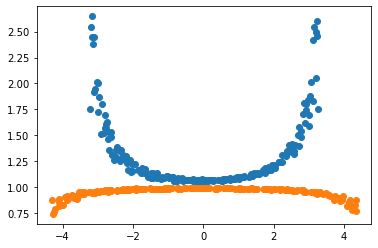

In [303]:
fig, ax = plt.subplots()
ax.plot(follicle.face_df.loc[follicle.apical_faces, "z"],
        follicle.face_df.loc[follicle.apical_faces, "weight"], 'o')
ax.plot(follicle.face_df.loc[follicle.basal_faces, "z"],
        follicle.face_df.loc[follicle.basal_faces, "weight"], 'o')

In [304]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}


In [305]:

ipv.clear()
follicle.face_df['visible'] = True
follicle.face_df.loc[follicle.basal_faces, 'visible'] = False

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [306]:
quasistatic_solve = True

if quasistatic_solve:
    solver = QSSolver()
    res = solver.find_energy_min(follicle, wgeom, model)
    print(res.message)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [312]:

ipv.clear()
follicle.face_df['visible'] = False
follicle.face_df.loc[follicle.apical_faces, 'visible'] = True

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0,…

In [313]:
import ipywidgets as widgets
from IPython.display import display

class MonolayerView(widgets.HBox):
    
    def __init__(self, eptm):
        
        plt.ioff()
        ipv.clear()
        self.fig3D, self.mesh = sheet_view(eptm, mode="3D", **draw_specs);
        self.graph_widget = widgets.Output()
        with self.graph_widget:
            
            self.fig2D, (self.ax0, self.ax1) = plt.subplots(2, 1, sharey=True, sharex=True)
            apical = eptm.get_sub_sheet('apical')
            apical.reset_index(),
            apical.reset_topo(),
            apical.face_df['visisble'] = True            
            _ = sheet_view(
                apical,
                mode="2D", coords=["x", "y"],
                ax=self.ax0,
                **draw_specs
            )
            basal = eptm.get_sub_sheet('basal')
            basal.face_df['visisble'] = True            
            basal.reset_index(),
            basal.reset_topo(),
            _ = sheet_view(
                basal,
                mode="2D",
                coords=["x", "y"],
                ax=self.ax1,
                **draw_specs
            )
            self.ax0.set_title('Apical mesh')
            self.ax1.set_title('Basal mesh')
            self.fig2D.set_size_inches(5, 8)
            plt.close(self.fig2D)
            display(self.fig2D)
            
        super().__init__([self.fig3D, self.graph_widget])
        
        

In [311]:
MonolayerView(follicle)

MonolayerView(children=(Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), projectionMatrix=(…

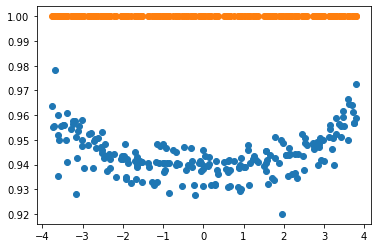

In [301]:
fig, ax = plt.subplots()

ax.plot(follicle.cell_df['z'], follicle.cell_df['vol'], "o")
ax.plot(follicle.cell_df['z'], follicle.cell_df['prefered_vol'], "o")


### Increasing lumen volume

In [117]:
if quasistatic_solve:
    solver = QSSolver()
    res = solver.find_energy_min(follicle, geom, model)
    print(res.message)


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [33]:

ipv.clear()

fig, mesh = sheet_view(follicle, mode="3D", **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

## Cell division and dynamic model

$$
\ln(V_\mathrm{lum})(t) = a + k_V t\\
V_\mathrm{lum}(t) = V_0 e^{k_V t}
$$



In [34]:
bck1 = follicle

In [121]:
follicle = bck1

# We take the time unit as 1/100th of a development stage

dt = 1e-2

default_division_spec = {
    "cell": -1,
    "growth_rate": 0.01,
    "critical_vol": 2.,
    "autonomous": True,
}

follicle.update_specs(
    {'settings':
     {
        # Critical length to trigger rearangements
        "threshold_length": 1e-1,  
        # Frequency of rearangements
        "p_4": 1.,
        "p_5+": 0.1,
    },
    'vert': {
        "viscosity": 0.1
    },
    'edge': {
        'is_valid': 1,
    }
})



# This will go in tyssue in the next release
@cell_lookup
def division(mono, manager, **kwargs):
    """Cell division happens through cell growth up to a critical volume,
    followed by actual division of the cell.
    
    Parameters
    ----------
    mono : a `Monolayer` instance
    manager : an `EventManager` instance
    cell_id : int,
      index of the mother cell
    growth_rate : float, default 0.1
      rate of increase of the prefered volume
    critical_vol : float, default 2.
      volume at which the cells stops to grow and devides
    """
    division_spec = default_division_spec
    division_spec.update(**kwargs)

    cell = division_spec["cell"]
    Vc = division_spec["critical_vol"] * mono.specs["cell"]["prefered_vol"]
    if mono.cell_df.loc[cell, "vol"] < Vc:
        dv = 1+division_spec["growth_rate"]*mono.settings['dt']
        da = dv**(1/3)
        increase(
            mono,
            'cell',
            cell,
            dv,
            "prefered_vol"
        )
        manager.append(division, **division_spec)
    else:
        print(f'division of cell {cell}')
        mono.cell_df.loc[cell, "prefered_vol"] = mono.specs["cell"]["prefered_vol"]
        daughter = cell_division(mono, cell, 'vertical')
        daughter_id = mono.cell_df.id.max() + 1
        mono.cell_df.loc[daughter, "id"] = daughter_id
        if division_spec["autonomous"]:
            manager.append(division, **division_spec)
            division_spec['cell_id'] = daughter_id
𝜂𝑣            
            
def lumen_growth(mono, manager, **kwargs):
    
    growth_rate = kwargs.get('growth_rate', 0.014)
    dt = mono.settings["dt"]
    mono.settings['lumen_prefered_vol'] *= 1 + growth_rate*dt
    manager.append(lumen_growth, **kwargs)
    

base_dir = Path("../data")
time_stamp = datetime.today().strftime("%y-%m-%d-%H-%M-%S")
history_file = Path(f"hist2D_{time_stamp}.hf5")


follicle.cell_df['id'] = follicle.cell_df.index.copy()

# Copy the initial follicle
eptm = follicle.copy()

eptm.edge_df[['srce', 'trgt']] = eptm.edge_df[['srce', 'trgt']].astype(int)

eptm.settings["dt"] = dt

manager = EventManager("cell")
# Auto solve rearangements
manager.append(reconnect)

for cell_id in eptm.cell_df['id']:
    manager.append(division, cell_id=cell_id)

manager.append(lumen_growth, growth_rate=1.4e-2)


history = HistoryHdf5(
    eptm,
    save_every=0.1,
    dt=dt,
    hf5file=base_dir / history_file,
    extra_cols={
        elem: list(follicle.datasets[elem].columns) for elem in follicle.datasets
    },  # record everything
)

solver = EulerSolver(
    eptm,
    geom,
    model,
    manager=manager,
    history=history,
    bounds=(
        -eptm.edge_df.length.median(),
        eptm.edge_df.length.median(),
    ),
)

manager.update()


$$\eta v = \sum F $$

In [127]:
solver.solve(120, dt)

In [128]:
browse_history(solver.history, **draw_specs)

interactive(children=(IntSlider(value=0, description='i', max=600), Output()), _dom_classes=('widget-interact'…

In [44]:
solver.eptm.settings

{'lumen_side': 'apical',
 'lumen_vol': 585.6510671007645,
 'lumen_vol_elasticity': 1.0,
 'lumen_prefered_vol': 649.8242879605406,
 'threshold_length': 0.1,
 'p_4': 1.0,
 'p_5+': 0.1,
 'dt': 0.01}

In [129]:
draw_specs = {
    'edge': {
        'visible': False,
    },
    'face': {
        'visible': True,
        'color': lambda sheet: sheet.face_df['area']
    },
}


browse_history(solver.history, **draw_specs)

interactive(children=(IntSlider(value=0, description='i', max=600), Output()), _dom_classes=('widget-interact'…